<a href="https://colab.research.google.com/github/FirefoxSRV/GlassClassification/blob/main/GlassClassification_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

data = pd.read_csv("glass.csv")
X = data.drop("Type", axis=1)

y = data["Type"] - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}

xgb_classifier = XGBClassifier(random_state=42)

grid_search = GridSearchCV(xgb_classifier, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_xgb_classifier = grid_search.best_estimator_

y_pred = best_xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print(f"Accuracy: {accuracy}")
print("\nConfusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification_rep)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.8372093023255814

Confusion Matrix:
[[10  1  0  0  0  0]
 [ 1 11  0  1  0  1]
 [ 1  0  2  0  0  0]
 [ 0  2  0  2  0  0]
 [ 0  0  0  0  3  0]
 [ 0  0  0  0  0  8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.79      0.79      0.79        14
           2       1.00      0.67      0.80         3
           3       0.67      0.50      0.57         4
           4       1.00      1.00      1.00         3
           5       0.89      1.00      0.94         8

    accuracy                           0.84        43
   macro avg       0.86      0.81      0.83        43
weighted avg       0.84      0.84      0.83        43



In [4]:
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.reshape(len(y_test),1)),1))

[[0 0]
 [5 5]
 [0 0]
 [5 5]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [4 4]
 [1 3]
 [1 1]
 [1 1]
 [4 4]
 [3 3]
 [5 5]
 [0 0]
 [0 0]
 [4 4]
 [1 1]
 [5 5]
 [5 5]
 [5 5]
 [2 2]
 [1 1]
 [0 0]
 [0 0]
 [1 3]
 [0 0]
 [1 0]
 [1 1]
 [2 2]
 [1 1]
 [0 0]
 [5 5]
 [3 3]
 [0 2]
 [0 1]
 [5 1]
 [3 1]
 [5 5]
 [0 0]]


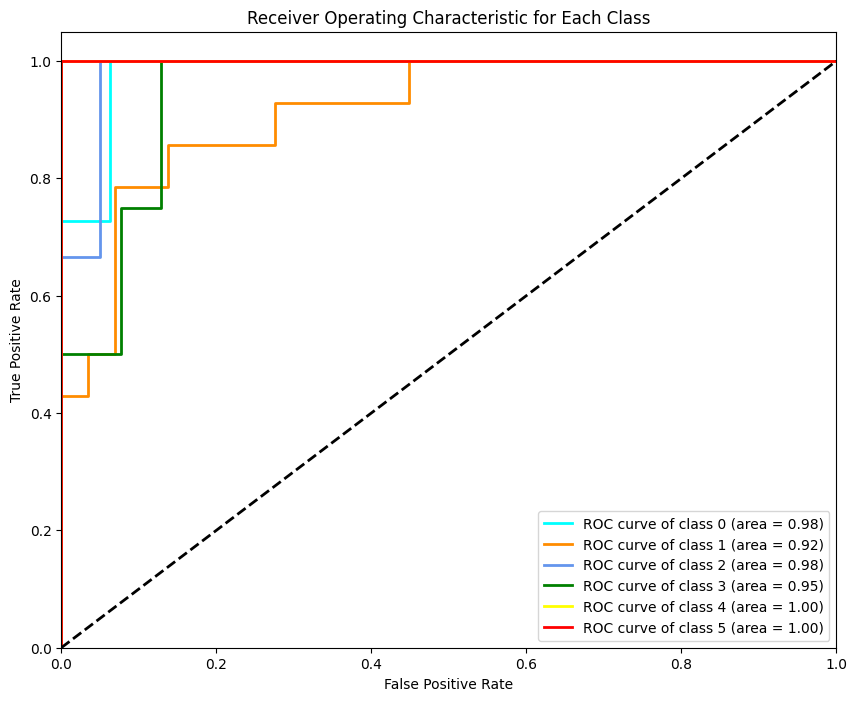

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

y_test_bin = label_binarize(y_test, classes=list(range(len(np.unique(y)))))
y_pred_prob = best_xgb_classifier.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y))
lw = 2

plt.figure(figsize=(10, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'yellow', 'red', 'purple'])

for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()


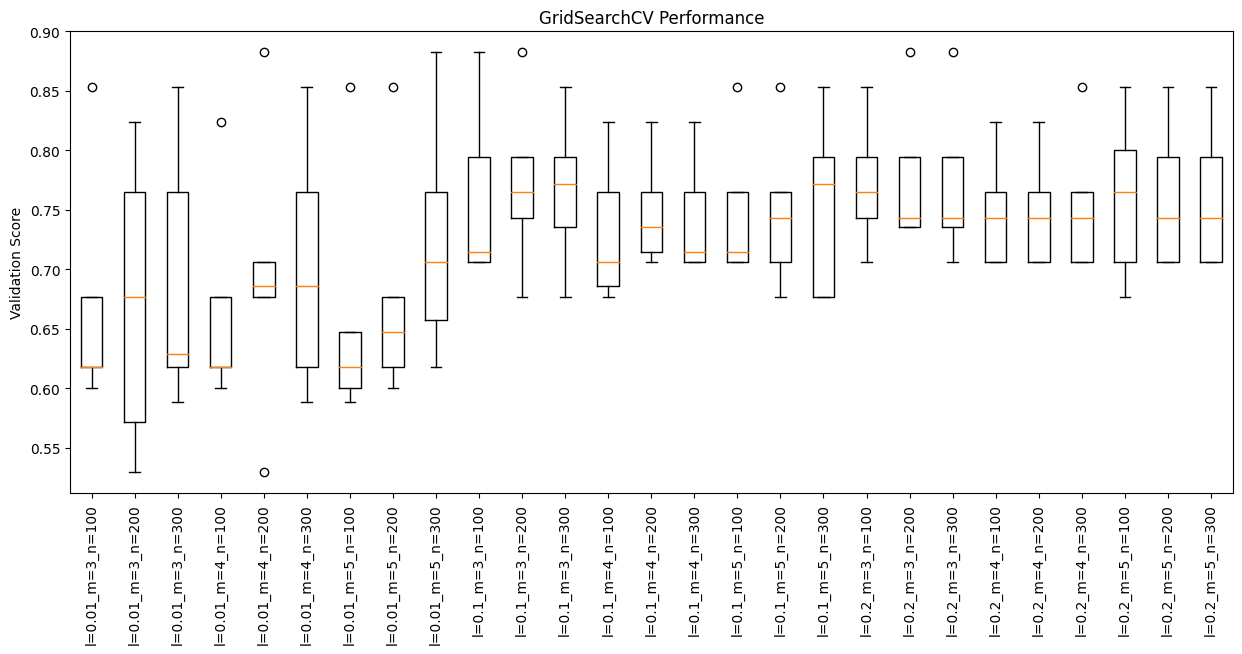

In [13]:
results = grid_search.cv_results_

# Extract scores for each parameter combination across the splits
all_test_scores = [results[f'split{i}_test_score'] for i in range(5)]
all_test_scores = list(zip(*all_test_scores))  # Transpose to get scores by parameter combination

# Create simplified labels for x-axis
param_combinations = ["_".join([f"{k[0]}={v}" for k, v in param.items()]) for param in results['params']]

plt.figure(figsize=(15, 6))
plt.title("GridSearchCV Performance")
plt.boxplot(all_test_scores, vert=True)
plt.xticks(np.arange(1, len(param_combinations) + 1), param_combinations, rotation=90)
plt.ylabel('Validation Score')
plt.show()


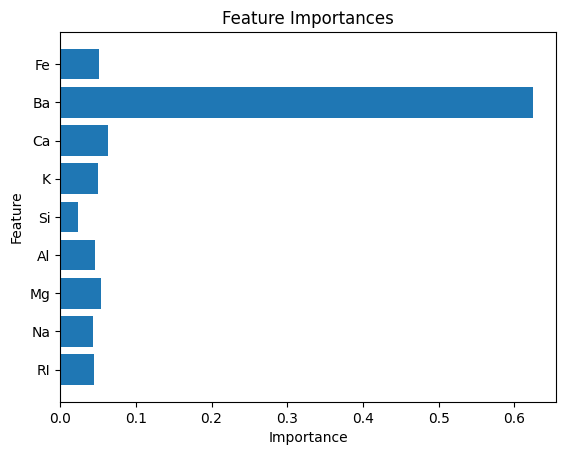

In [14]:
plt.barh(X.columns, best_xgb_classifier.feature_importances_)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()